**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

**Curso: TC4029 - Ciencia y analítica de datos**

Tecnológico de Monterrey

Prof Grettel Barceló Alonso

**Semana 8**
Regresión Lineal

---

*   NOMBRE: ---------------------------------------------------------
*   MATRÍCULA: ----------------------------------------------------

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
DIR = "/content/drive/MyDrive/Colab Notebooks/MNA/TC4029 - Ciencia y analítica de datos/Semana 8/Actividad8_RLineal"
os.chdir(DIR)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
insurance_df = pd.read_csv('insurance.csv')
insurance_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


# **Parte 1**. EDA

Efectúa una exploración inicial de los datos a través de:

1a) Estadísticas descriptivas para todas las variables del dataframe.

In [5]:
display(insurance_df.describe())
insurance_df.select_dtypes(include=object).describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


1b) Búsqueda de valores faltantes.

In [7]:
insurance_df.isnull().mean()*100

,0
age,0.0
sex,0.0
bmi,0.0
children,0.0
smoker,0.0
region,0.0
charges,0.0


1c) Histrogramas y boxplots para las variables cuantitativas y diagramas de barras con la frecuencia para las variables categóricas.

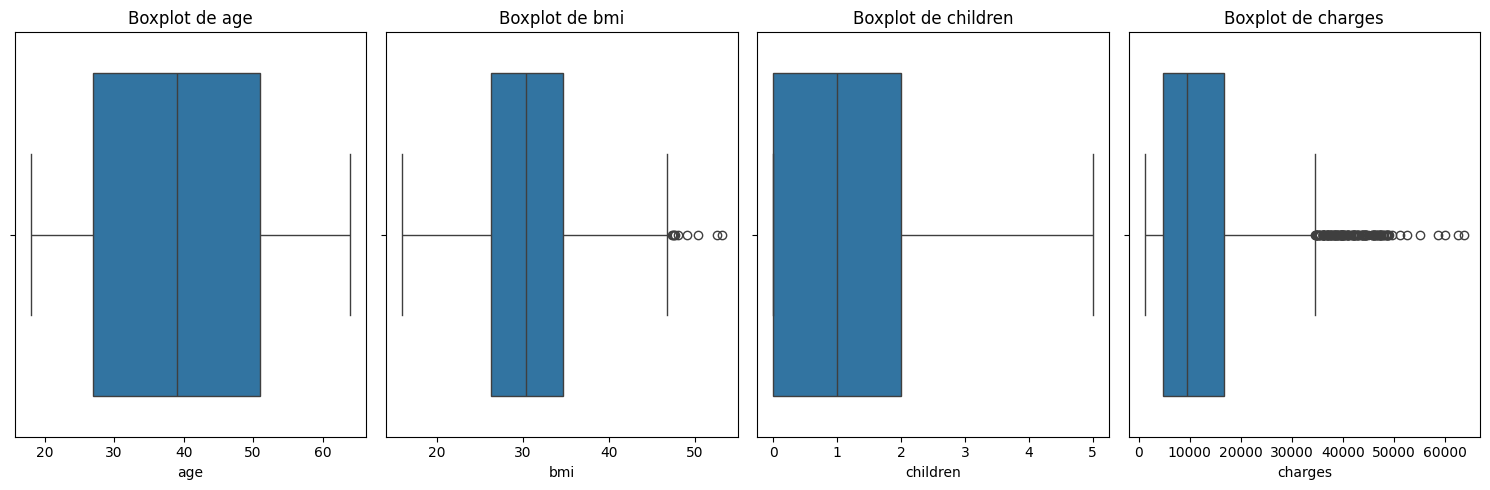

In [20]:
#Cuantitativos
columnas = insurance_df.select_dtypes(exclude=object).columns
plt.figure(figsize=(15, 5))
for i, col in enumerate(columnas, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(x=insurance_df[col])
    plt.title(f"Boxplot de {col}")
    plt.xlabel(col)
plt.tight_layout()

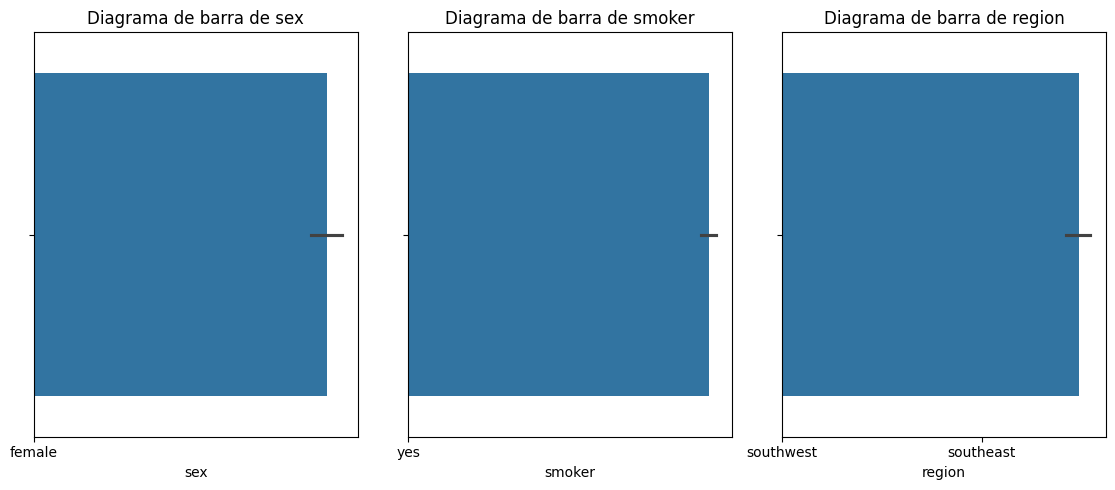

In [22]:
#Cualitativos
columnas = insurance_df.select_dtypes(include=object).columns
plt.figure(figsize=(15, 5))
for i, col in enumerate(columnas, 1):
    plt.subplot(1, 4, i)
    sns.barplot(x=insurance_df[col])
    plt.title(f"Diagrama de barra de {col}")
    plt.xlabel(col)
plt.tight_layout()

Para responder los siguientes cuestionamientos, genera los gráficos indicados:

2a) ¿Hay diferencias significativas de las primas según el sexo? Compara la distribución de la variable `charges` por medio de un boxplot.

2b) Crea un diagrama de dispersión de `charges` versus el `bmi` que incorpore la distinción por las categorías `smoker` y `children` (tip: utiliza el parámetro `size`) ¿Hay alguna conclusión importante que se derive del gráfico?

2c) Elabora un mapa de calor que muestre la correlación de las variables numéricas.

Obtén un dataframe con las observaciones que tengan valores atípicos en `charges`.

3a) ¿Cuál es el promedio de `age` y de `bmi` en el dataframe de valores atípicos obtenido?

3b) ¿Qué porcentaje de estas observaciones (en el dataframe de valores atípicos obtenidos) se corresponden a mujeres y a hombres? ¿A fumadores y no fumadores?

# **Parte 2**. Preprocesamiento

4. Separa las variables del dataframe: en `X` coloca los predictores y en `y` la variable de respuesta o salida (`charges`).

5. Divide el conjunto en entrenamiento y prueba (80:20) considerando:


*   El parámetro `random_state` con el valor de 1 para garantizar reproducibilidad.
*   Analiza los diagramas de barras obtenidos en el ejercicio 1c. Con los resultados observados, es conveniente usar la variable `smoker` en la estrategia de estratificación.
*   Como ya tienes separadas en `X` e `y` los predictores y salida, consulta cómo ejecutar la función `train_test_split()` para obtener `Xtrain, Xtest, ytrain, ytest` en una única instrucción.

6. Prepara un transformador, denominado `preprocessing`, para aplicar escalamiento *MinMax* a los predictores numéricos y codificación *one-hot* a los categóricas.

# **Parte 3**. Entrenando y evaluando el modelo de RL

7. Ejecuta un pipeline con el transformador creado y el algoritmo de regresión lineal para entrenar un modelo denominado `lr_model`.

Evalúa el modelo en el conjunto de prueba y obtén la raíz del error cuadrático medio (`RMSE`) y la métrica `R` cuadrado ($R^2$). Aunque ésta última la estudiarás a detalle la próxima semana, ahora sólo debes saber que toma valores entre 0 y 1, donde 1 indica un ajuste perfecto y, por tanto, un modelo muy fiable para las previsiones futuras. La función de scikit-learn que determina esta métrica es: [`r2_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)

**Valora el rendimiento del modelo con los siguientes cambios:**


8. Reemplaza los outliers de `charges` con el límite superior (`Q3 + 1.5 * IQR`). Haz el cambio en ambos conjuntos: `ytrain` y `ytest`, previo a la aplicación del mismo pipeline. Guarda el modelo como `lr_model2`.


9. Prepara otro transformador, denominado `preprocessing2`, para aplicar escalamiento estándar a los predictores numéricos y codificación ordinal a los categóricas. Aplícalo en un nuevo pipeline utilizando nuevamente regresión lineal. Guarda el modelo como `lr_model3`.

**Nota.** Los cambios se ejecutan de manera consecutiva, por ejemplo: el reemplazo de los outliers también se ejecuta previo al transformador `preprocessing2` y así sucesivamente.

10. Utiliza regresión polinomial para verificar si se produce un mejor ajuste. Intenta con varios grados, aunque debes dejar en el código sólo el de mejor rendimiento. Guarda el modelo como `lr_model4`.